In [1]:
%load_ext autoreload
%autoreload 2

# PriorVAE: comparing different loss functions - visualisation of ARC training

**Current issue**: the decoder weights are v. close to zero (but non-zero, ish)

For a 1D GP

In [2]:
from jax import random
import jax.numpy as jnp

import time
import dill
from flax import serialization

# Numpyro
import numpyro
from numpyro.infer import MCMC, NUTS, init_to_median, Predictive


In [3]:
numpyro.set_host_device_count(3)

In [4]:
path = "./learnt_models/04_1000_batches_gpu_args.dill"

with open(path, "rb") as f:
    args = dill.load(f)

args["pretrained_vae"] = True

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[-0.00048828  0.00048828  0.         -0.00024414  0.          0.
  0.00024414  0.00012207 -0.00012207  0.          0.         -0.00024414
  0.          0.          0.         -0.00012207 -0.00012207  0.00012207
  0.          0.         -0.00012207  0.          0.          0.
  0.          0.          0.         -0.00012207  0.          0.
  0.          0.00012207  0.          0.00012207 -0.00012207  0.
  0.          0.         -0.00012207  0.          0.         -0.00024414
 -0.00012207  0.00012207  0.          0.00012207  0.          0.
 -0.00012207  0.          0.          0.         -0.00012207  0.
  0.          0.          0.          0.          0.00036621  0.
  0.          0.          0.         -0.00012207 -0.00012207  0.
 -0.00012207  0.00012207  0.          0.          0.00012207  0.
  0.          0.00012207  0.00012207  0.          0.00012207  0.00012207
  0.00012207  0.00024414  0.         -0.00012207  0.00012207  0.
  0.00012207 -0.00012207  0.         -0.00024414  0.      

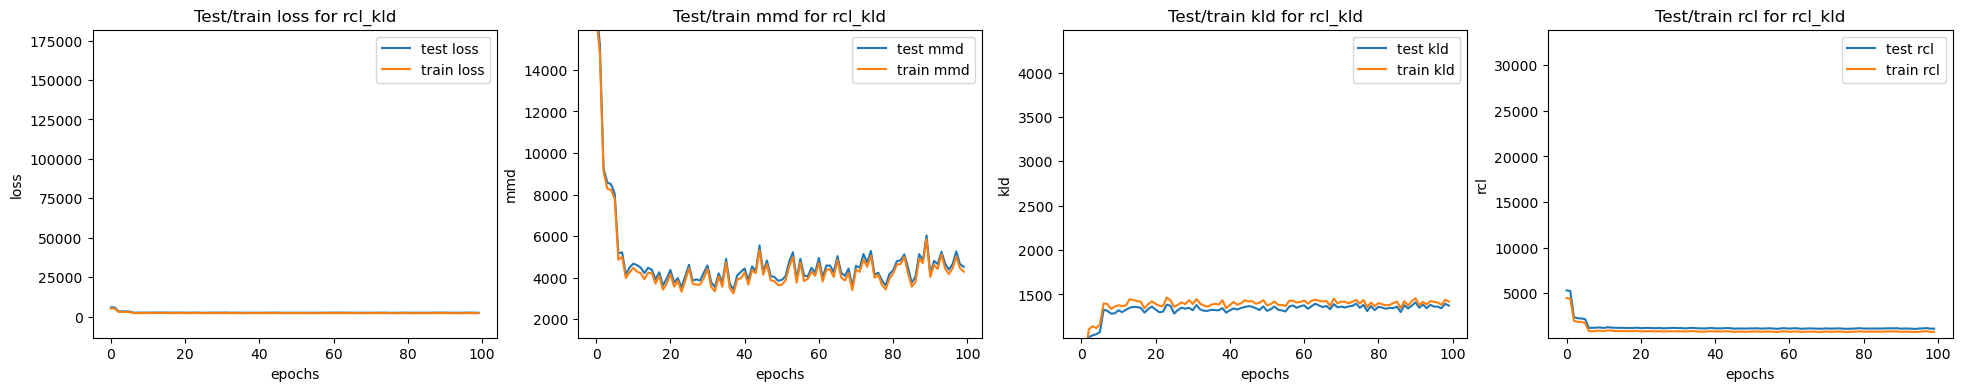

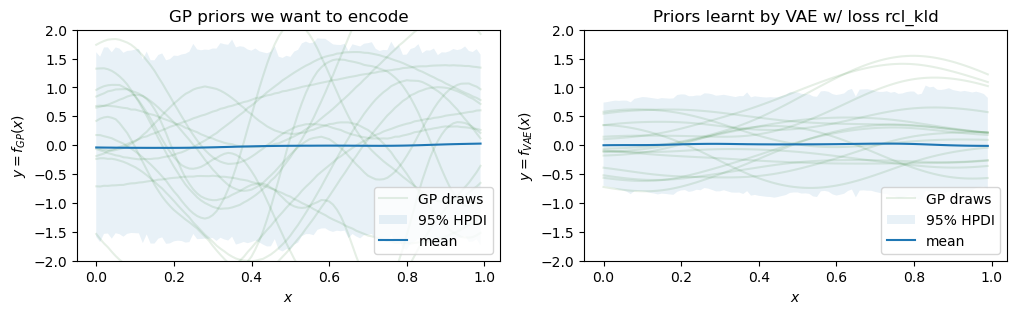

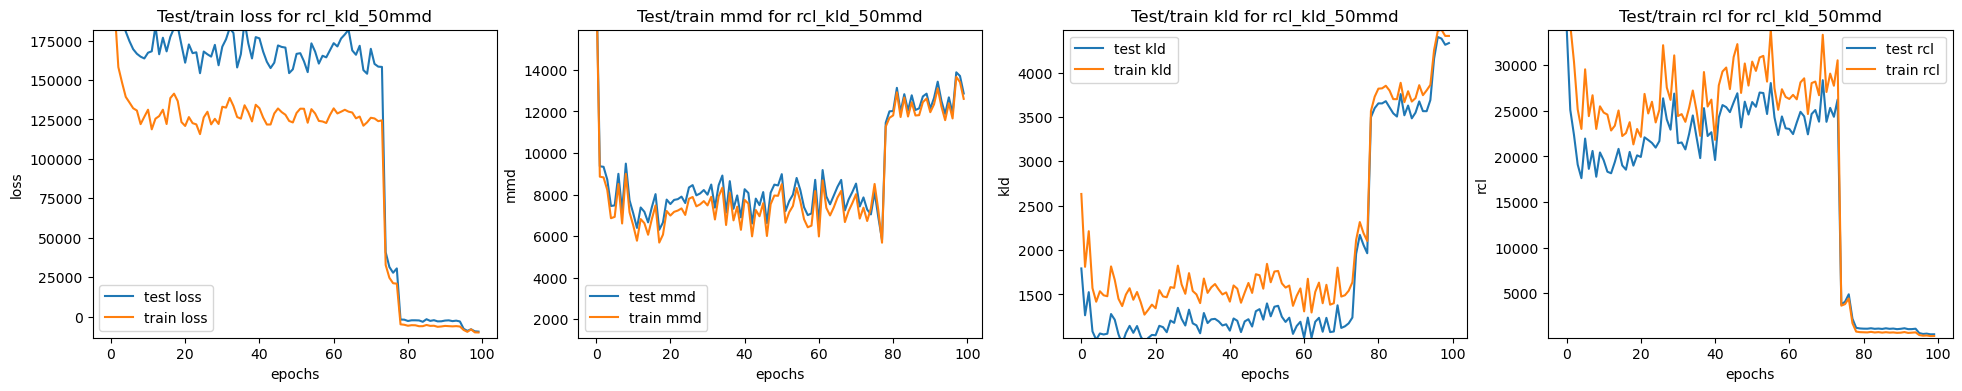

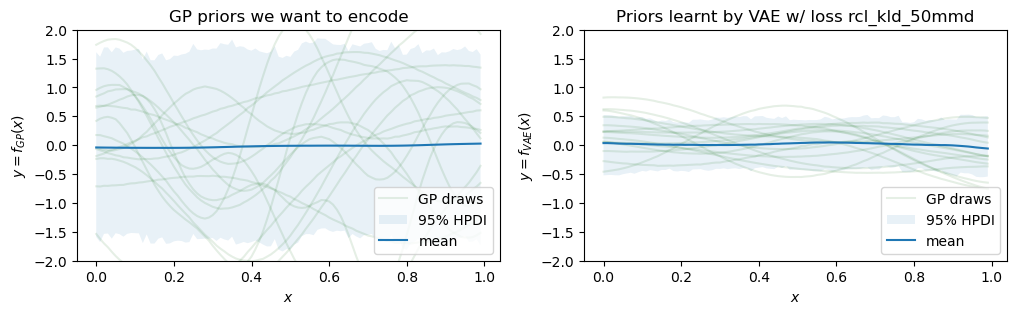

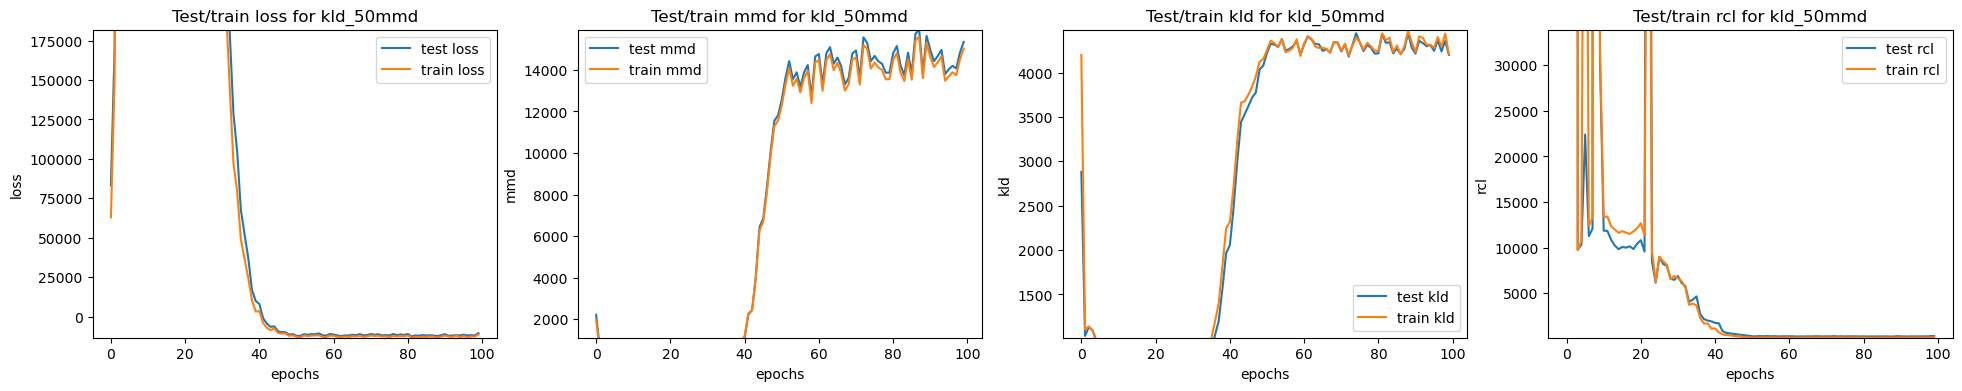

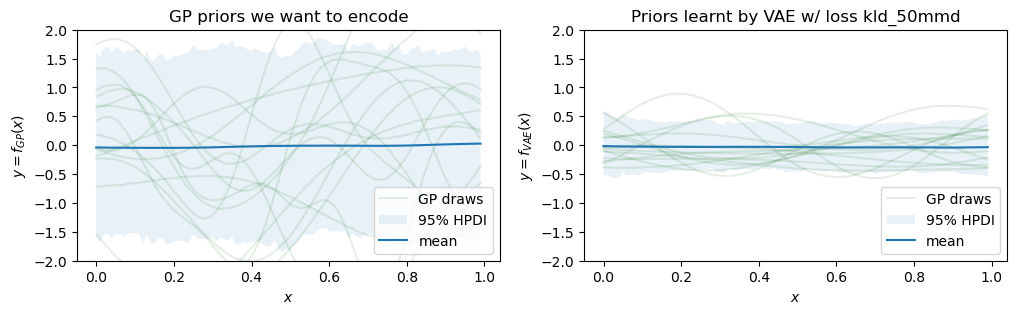

In [32]:

from reusable.util import decoder_filename, get_savepath
import matplotlib.pyplot as plt
from plotting.plots import plot_training, compare_draws

from reusable.gp import OneDGP
from reusable.vae import vae_sample

from reusable.vae import VAE_Decoder

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)
gp_draws = plot_gp_predictive(rng_key_gp, x=args["x"], gp_kernel = args["gp_kernel"], jitter=1e-5)['y']

# TODO: remove
args["loss_functions"] = ["rcl_kld", "rcl_kld_50mmd", "kld_50mmd"]

to_plot = ["loss", "mmd", "kld", "rcl"]

ylims = [[0,0], [0,0], [0,0],[0,0]]

flattenned_histories = {}

cutoff = 40

histories = {}
for loss_fn in args["loss_functions"]:
    file_path = f'{get_savepath()}/{decoder_filename("04", args, suffix=loss_fn+"_metrics_hist")}'

    with open(file_path, 'rb') as file:
        metrics_history = dill.load(file)

    histories[loss_fn] = metrics_history

    if loss_fn == "rcl_kld":
        print (metrics_history["test_loss"] - metrics_history["test_kld"] - metrics_history["test_rcl"])

    if loss_fn == "rcl_kld_50mmd":
        print (metrics_history["test_loss"] - metrics_history["test_kld"] - metrics_history["test_rcl"] - 50 * metrics_history["test_mmd"])

    if loss_fn == "kld_50mmd":
        print ("kld_50mmd", metrics_history["train_loss"] - metrics_history["train_kld"] - 50* metrics_history["train_mmd"])

    for key, value in metrics_history.items():
        print(key, jnp.max(value[cutoff:]))
        if key in flattenned_histories:
            flattenned_histories[key] = jnp.concatenate((flattenned_histories[key], value[cutoff:]), axis=0)
        else:
            flattenned_histories[key] = value[cutoff:]



for i,t in enumerate(to_plot):
    ylims[i][0] = min(jnp.min(flattenned_histories["test_"+t]), jnp.min(flattenned_histories["train_"+t]))
    ylims[i][1] = max(jnp.max(flattenned_histories["test_"+t]), jnp.max(flattenned_histories["train_"+t]))

print(ylims)


for loss_fn in args["loss_functions"]:
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 4))

    for i,t in enumerate(to_plot):
        plot_training(
            jnp.array(histories[loss_fn]["test_"+t]).flatten(),
            jnp.array(histories[loss_fn]["train_"+t]).flatten(),
            f"Test/train {t} for " + loss_fn,
            t,
            axs[i],
            ylims = ylims[i]
        )
    plt.show()

    dummy_decoder = VAE_Decoder(hidden_dim1=args["hidden_dim1"],   hidden_dim2=args["hidden_dim2"], out_dim=args["n"])
    dummy_params = dummy_decoder.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))
    file_path = f'{get_savepath()}/{decoder_filename("04", args, suffix=loss_fn)}'

    with open(file_path, 'rb') as file:
        bytes = file.read()
        
        args["decoder_params"] = serialization.from_bytes(dummy_params, bytes)

    plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
    vae_draws = plot_vae_predictive(
        rng_key_predict,
        hidden_dim1=args["hidden_dim1"],
        hidden_dim2=args["hidden_dim2"],
        latent_dim=args["latent_dim"],
        out_dim=args["n"],
        decoder_params=args["decoder_params"],
    )["f"]
          
    compare_draws(args["x"], gp_draws, vae_draws, "GP priors we want to encode", "Priors learnt by VAE w/ loss " + loss_fn, '$y=f_{GP}(x)$', '$y=f_{VAE}(x)$')
    plt.show()

        